In [2]:
!pip install -q sentence-transformers
!pip install torch
!pip install catboost
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
import os
from sentence_transformers import SentenceTransformer, util
import torch
import sys
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
import numpy as np
from tqdm import notebook, tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.linear_model import Ridge

# Подготовка и предобработка данных

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [6]:
path = os.path.abspath(os.curdir)
path

'/content/drive/My Drive/Colab Notebooks'

In [7]:
covers = pd.read_json(os.path.join(path, 'covers.json'), orient='columns', lines=True)

In [8]:
print(sum(covers['track_remake_type'] == 'ORIGINAL'), sum(covers['track_remake_type'] == 'COVER'))

4293 67304


Наблюдается дисбаланс классов

In [9]:
#covers.isna().sum()

In [10]:
#covers[covers['track_remake_type'] == 'ORIGINAL'].isna().sum()

In [11]:
#covers[(covers['track_remake_type'] == 'COVER') & (covers['original_track_id'].isna() == False)]

Только у 528 каверов есть оригинальный трек

In [12]:
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [13]:
lyrics = pd.read_json(os.path.join(path, 'lyrics.json'), orient='columns', lines=True)

In [14]:
lyrics['text'].nunique()

10644

In [15]:
lyrics['track_id'].nunique()

10277

In [16]:
lyrics['lyricId'].nunique()

10915

In [17]:
lyrics[['track_id', 'text']].duplicated().sum()

264

In [18]:
lyrics = lyrics.drop_duplicates(subset=['track_id', 'text'], keep='first')

Встречаются строки, где track_id и текст одинаковые, но lyricid разные. Я решила удалить эти строки.

In [19]:
meta = pd.read_json(os.path.join(path, 'meta.json'), orient='columns', lines=True)

In [20]:
meta['track_id'].nunique()

71768

In [21]:
#meta[meta['isrc'].duplicated(keep=False) & meta['isrc'].notna() & meta['duration'] > 0].sort_values(by='isrc')

In [22]:
#meta[meta['duration'] == 0]

In [23]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


In [24]:
meta['language'].nunique()

85

In [25]:
meta['title'].nunique()

45462

In [26]:
meta['isrc'].nunique() # минус пропущенные, получается 172 дублируются

71283

In [27]:
meta = meta.dropna(subset='track_id').reset_index(drop=True)

In [28]:
#meta.isna().sum()

In [29]:
for index in range(len(meta)):
  if (meta.loc[index, 'genres'] is None) or (len(meta.loc[index, 'genres']) < 3):
    meta.loc[index, 'genres'] = 'unknown'
  else:
    meta.loc[index, 'genres'] = ', '.join(meta.loc[index, 'genres'])

In [30]:
#meta[meta['isrc'].isna() == True]

In [31]:
data = covers.merge(lyrics, on='track_id', how='left')
data = data.merge(meta, on='track_id', how='left')

In [32]:
#data.head()

Встречаются дубликаты, у которых разные тексты. Их стоит удалить?

In [33]:
#data.isna().sum()

In [34]:
data.loc[data['track_remake_type']=='COVER','track_remake_type'] = 0
data.loc[data['track_remake_type']=='ORIGINAL', 'track_remake_type'] = 1

In [35]:
data = data.drop(['lyricId', 'original_track_id'], axis=1)

In [36]:
data[['track_id', 'isrc']].duplicated().sum()

752

In [37]:
data = data.drop_duplicates(subset=['track_id', 'isrc'], keep='first').reset_index(drop=True)

In [38]:
data['isrc'].duplicated().sum() # может быть такое, что у нескольких track_id один isrc? разное название у одинаковых песен

481

In [39]:
data = data.drop_duplicates(subset='isrc', keep='first').reset_index(drop=True)

In [40]:
data['genres'].nunique()

71

In [41]:
data['track_remake_type'] = data['track_remake_type'].astype('int')

In [42]:
#data.isna().sum()

In [43]:
data = data.dropna(subset='isrc')

In [44]:
data = data.drop(['track_id', 'language'], axis=1)

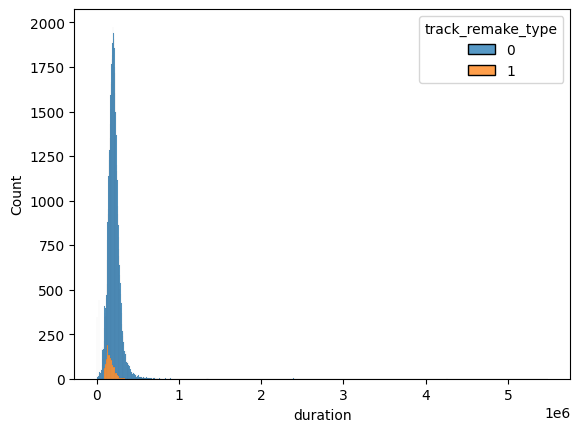

In [45]:
sns.histplot(data, x = 'duration', hue = 'track_remake_type', multiple = 'stack');

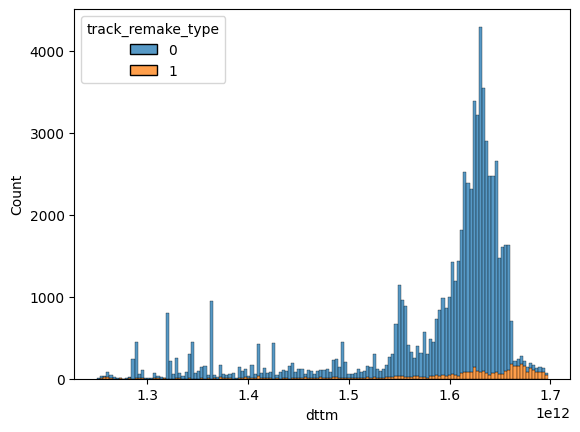

In [46]:
sns.histplot(data, x = 'dttm', hue = 'track_remake_type', multiple = 'stack');

У всех оригиналов время выхода раньше, что логично

In [47]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [48]:
model = SentenceTransformer('sentence-transformers/LaBSE')

In [49]:
data_known_text = data[data['text'].isna() == False]

In [50]:
all_texts = list(data_known_text["text"])

In [51]:
embedding_all_texts = model.encode(all_texts, show_progress_bar=True, device=device, batch_size=32)

Batches:   0%|          | 0/312 [00:00<?, ?it/s]

In [52]:
data_known_text['dttm'].info()

<class 'pandas.core.series.Series'>
Int64Index: 9974 entries, 0 to 71049
Series name: dttm
Non-Null Count  Dtype  
--------------  -----  
9974 non-null   float64
dtypes: float64(1)
memory usage: 155.8 KB


# Функции построения моделей

In [53]:
def LogReg(features_train, target_train):
  model = LogisticRegression()
  grid = GridSearchCV(estimator=model, cv=5, param_grid={}, scoring='roc_auc')
  grid.fit(features_train, target_train)
  return grid

In [54]:
def LinRid(features_train, target_train):
  model =  Ridge(random_state=12345)
  grid = GridSearchCV(model, param_grid={'alpha': np.arange(0, 0.5, 0.02)},
                    scoring='roc_auc', cv=5)
  grid.fit(features_train, target_train)
  return grid

In [55]:
def RFC(features_train, target_train):
  model = RandomForestClassifier()
  grid = GridSearchCV(model, param_grid={'max_depth': range(1, 20), 'n_estimators': range(10, 31, 10)},
                           scoring='roc_auc', cv=5)
  grid.fit(features_train, target_train)
  return grid

In [56]:
def Cat(features_train, target_train):
  params = {
    'loss_function' : 'Logloss',
    'random_state' : 12345
    }
  model = CatBoostClassifier(params)
  grid = GridSearchCV(model, param_grid={'learning_rate': np.arange(0.05, 0.41, 0.05), 'depth': [6, 7, 8, 9],
                                           'iterations': [100]}, scoring='roc_auc', cv=5)
  grid.fit(features_train, target_train)
  return grid

# Модели с одним признаком (embedding) по срезу данных

In [57]:
features = embedding_all_texts

target = data_known_text['track_remake_type']
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.2, random_state=12345, stratify=target)

In [58]:
model_log1 = LogReg(features_train, target_train)
model_log1.best_score_

0.8574923586402885

In [59]:
model_rid1 = LinRid(features_train, target_train)
print(model_rid1.best_score_, model_rid1.best_params_)

0.8657069723438884 {'alpha': 0.14}


In [60]:
model_forest1 = RFC(features_train, target_train)
print(model_forest1.best_score_, model_forest1.best_params_)

0.8285697661641457 {'max_depth': 14, 'n_estimators': 30}


In [66]:
#model_cat1 = Cat(features_train, target_train)
#print(model_cat1.best_score_, model_cat1.best_params_)

# Модели с признаками dttm и duration

In [61]:
features = data[['dttm', 'duration']]
target = data['track_remake_type']
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.2, random_state=12345, stratify=target)

In [62]:
model_rid2 = LinRid(features_train, target_train)
print(model_rid2.best_score_, model_rid2.best_params_)

0.7180660363457546 {'alpha': 0.0}


In [63]:
model_forest2 = RFC(features_train, target_train)
print(model_forest2.best_score_, model_forest2.best_params_)

0.867938206756882 {'max_depth': 12, 'n_estimators': 30}


In [67]:
#model_cat2 = Cat(features_train, target_train)
#print(model_cat2.best_score_, model_cat2.best_params_)

In [69]:
from sklearn.metrics import roc_auc_score

# Разделение на обучающую и тестовую выборки
features = embedding_all_texts
target = data_known_text['track_remake_type']

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.2, random_state=12345, stratify=target)
predictions = []

# создание базовых моделей

model_forest = RandomForestClassifier(n_estimators=model_forest1.best_params_['n_estimators'], max_depth=model_forest1.best_params_['max_depth'], random_state=12345)
model_forest.fit(features_train, target_train)
predictions_forest = model_forest.predict(features_test)
predictions.append(predictions_forest)

features = data_known_text[['dttm', 'duration']]
features_train, features_test = train_test_split(features, test_size=0.2, random_state=12345, stratify=target)

model_ridge = Ridge(alpha=model_rid2.best_params_['alpha'], random_state=12345)
model_ridge.fit(features_train, target_train)
predictions_ridge = model_ridge.predict(features_test)
predictions.append(predictions_ridge)

In [72]:
# Создание метамодели
# meta_model = LogisticRegression(random_state=12345) => roc_auc = 0.71
meta_model = Ridge(random_state=12345)

# Преобразование предсказаний базовых моделей в новый набор данных
meta_features = np.column_stack(predictions)

# Обучение метамодели на новых признаках
meta_model.fit(meta_features, target_test)

# Получение предсказаний метамодели
meta_predictions = meta_model.predict(meta_features)

# Оценка качества предсказаний метамодели
roc_auc_score(target_test, meta_predictions)

0.8170651675139136